# Study of the evolution of temperatures in cities
We are going to try to predict temperatures on precise points on Earth based on the latitude, the longitude, the major city and the date. For this dataset (https://www.kaggle.com/datasets/berkeleyearth/climate-change-earth-surface-temperature-data?resource=download), the temperatures were recorded from 1743 to 2013.

In [27]:

import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from numpy import log

import optuna
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import pickle
import os

#Test de plusieurs modèles
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder


In [28]:
import pandas as pd
import numpy as np
ByMajorCity= pd.read_csv('./Data/GlobalLandTemperaturesByMajorCity.csv')

# First pre-treatments

In [29]:
def count_nan(dataframe):
    # Calculate the sum of NaN in the data frame
    total_nan = dataframe.isna().sum().sum()

    nan_per_column = dataframe.isna().sum()

    return total_nan, nan_per_column

In [30]:
total_nan, nan_per_column = count_nan(ByMajorCity)

print("Shape de la matrice: ", ByMajorCity.shape)
print(f"Nombre total de NaN dans le DataFrame : {total_nan}")
print("Nombre de NaN par colonne :")
print(nan_per_column)

ByMajorCity

Shape de la matrice:  (239177, 7)
Nombre total de NaN dans le DataFrame : 22004
Nombre de NaN par colonne :
dt                                   0
AverageTemperature               11002
AverageTemperatureUncertainty    11002
City                                 0
Country                              0
Latitude                             0
Longitude                            0
dtype: int64


,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1849-01-01,26.704,1.435,Abidjan,Côte D'Ivoire,5.63N,3.23W
1,1849-02-01,27.434,1.362,Abidjan,Côte D'Ivoire,5.63N,3.23W
2,1849-03-01,28.101,1.612,Abidjan,Côte D'Ivoire,5.63N,3.23W
3,1849-04-01,26.140,1.387,Abidjan,Côte D'Ivoire,5.63N,3.23W
4,1849-05-01,25.427,1.200,Abidjan,Côte D'Ivoire,5.63N,3.23W
...,...,...,...,...,...,...,...
239172,2013-05-01,18.979,0.807,Xian,China,34.56N,108.97E
239173,2013-06-01,23.522,0.647,Xian,China,34.56N,108.97E
239174,2013-07-01,25.251,1.042,Xian,China,34.56N,108.97E
239175,2013-08-01,24.528,0.840,Xian,China,34.56N,108.97E


Considering the small amount of NaNs in our DataFrame, we will just simply drop the lines containing NaNs values.

In [31]:
ByMajorCity_sans_NA=ByMajorCity.dropna()

In [32]:
ByMajorCity_sans_NA['dt'] = pd.to_datetime(ByMajorCity_sans_NA['dt'])

C:\Users\valentin\AppData\Local\Temp\ipykernel_11932\1975194507.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ByMajorCity_sans_NA['dt'] = pd.to_datetime(ByMajorCity_sans_NA['dt'])


In [33]:
#Here we drop the City column because we consider that the coordinates already provide a similar information and the City feature contains also a lot of values
#We also drop the 'AverageTemperatureUncertainty' feature because of its close relation to the target variable
ByMajorCity_true=ByMajorCity_sans_NA.drop(columns=['City','AverageTemperatureUncertainty'])

In [34]:
#Here we encode our categorical variables

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the 'Country' column
ByMajorCity_true['Country'] = label_encoder.fit_transform(ByMajorCity_true['Country'])

In [35]:
# ByMajorCity_true = ByMajorCity_true.drop(ByMajorCity_true.columns[-1], axis=1)
ByMajorCity_true

,dt,AverageTemperature,Country,Latitude,Longitude
0,1849-01-01,26.704,11,5.63N,3.23W
1,1849-02-01,27.434,11,5.63N,3.23W
2,1849-03-01,28.101,11,5.63N,3.23W
3,1849-04-01,26.140,11,5.63N,3.23W
4,1849-05-01,25.427,11,5.63N,3.23W
...,...,...,...,...,...
239171,2013-04-01,12.563,8,34.56N,108.97E
239172,2013-05-01,18.979,8,34.56N,108.97E
239173,2013-06-01,23.522,8,34.56N,108.97E
239174,2013-07-01,25.251,8,34.56N,108.97E


# Statistical Approach

First, considering this is a time-series problem, we will try to predict the temperatures thanks to statistical methods.

In [104]:
df=pd.read_csv("data/GlobalLandTemperaturesByMajorCity.csv")

In [105]:
def downcast_dtypes(df):
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols = [c for c in df if df[c].dtype in ["int64", "int32"]]
    df[float_cols] = df[float_cols].astype(np.float16)
    df[int_cols] = df[int_cols].astype(np.int8)
    return df
df = downcast_dtypes(df)


In [106]:
#df.isnull().sum()
df.set_index(keys="dt", inplace=True)

## Baseline: ARIMA MODEL

### So what exactly is an ARIMA model?

ARIMA, short for ‘Auto Regressive Integrated Moving Average’ is actually a class of models that ‘explains’ a given time series based on its own past values, that 

is, its own lags and the lagged forecast errors, so that equation can be used to forecast future values.

Any ‘non-seasonal’ time series that exhibits patterns and is not a random white noise can be modeled with ARIMA models.

An ARIMA model is characterized by 3 terms: p, d, q

where,

p is the order of the AR term

q is the order of the MA term

d is the number of differencing required to make the time series stationary

### What does the p, d and q in ARIMA model mean?

The first step to build an ARIMA model is to make the time series stationary.

Why?

Because, term ‘Auto Regressive’ in ARIMA means it is a linear regression model that uses its own lags as predictors. Linear regression models, as you know, work best when the predictors are not correlated and are independent of each other.

So how to make a series stationary?

The most common approach is to difference it. That is, subtract the previous value from the current value. Sometimes, depending on the complexity of the series, more than one differencing may be needed.

The value of d, therefore, is the minimum number of differencing needed to make the series stationary. And if the time series is already stationary, then d = 0.

Next, what are the ‘p’ and ‘q’ terms?

‘p’ is the order of the ‘Auto Regressive’ (AR) term. 

It refers to the number of lags of Y to be used as predictors.

 And ‘q’ is the order of the ‘Moving Average’ (MA) term.
 
  It refers to the number of lagged forecast errors that should go into the ARIMA Model.

### How to find out p, d et q

In [107]:
# First, I am going to check if the series is stationary using the Augmented Dickey Fuller test (adfuller()), from the statsmodels package.
# The null hypothesis is non- stationary


df=ByMajorCity_true
result = adfuller(df["AverageTemperature"].dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -6.346705
p-value: 0.000000


Since P-value is less than (0.05) we faced non-stationary situation.

W'll use ACF( Autocorrelation function) and PACF ( Partial autocorrelation) to try to figure out ARIMA  orders parameters

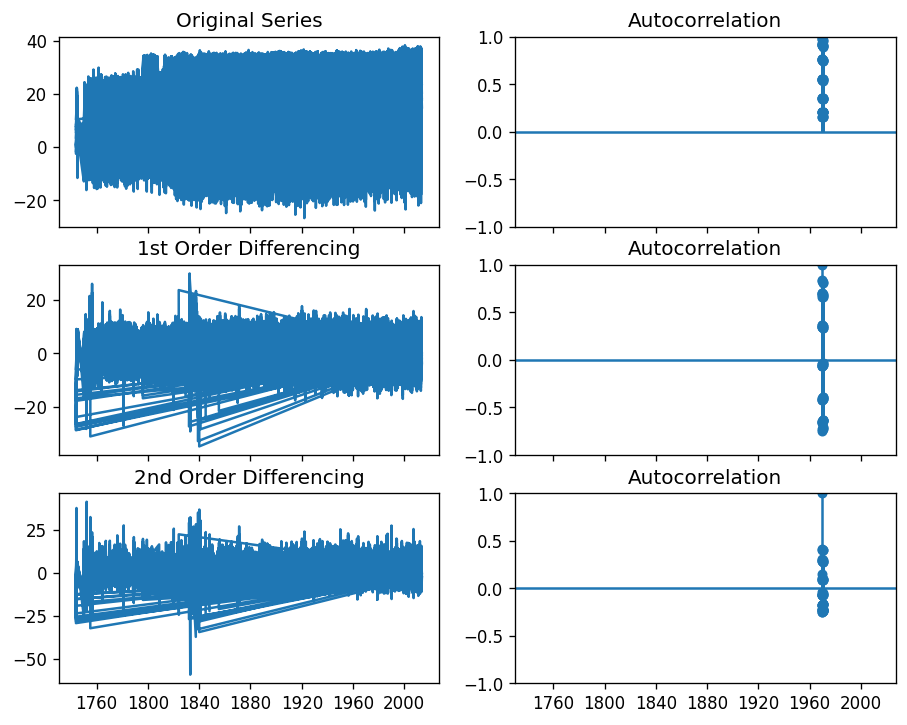

In [108]:
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})
# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(df["AverageTemperature"]); axes[0, 0].set_title('Original Series')
plot_acf(df["AverageTemperature"], ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df["AverageTemperature"].diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df["AverageTemperature"].diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(df["AverageTemperature"].diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df["AverageTemperature"].diff().diff().dropna(), ax=axes[2, 1])
plt.show()

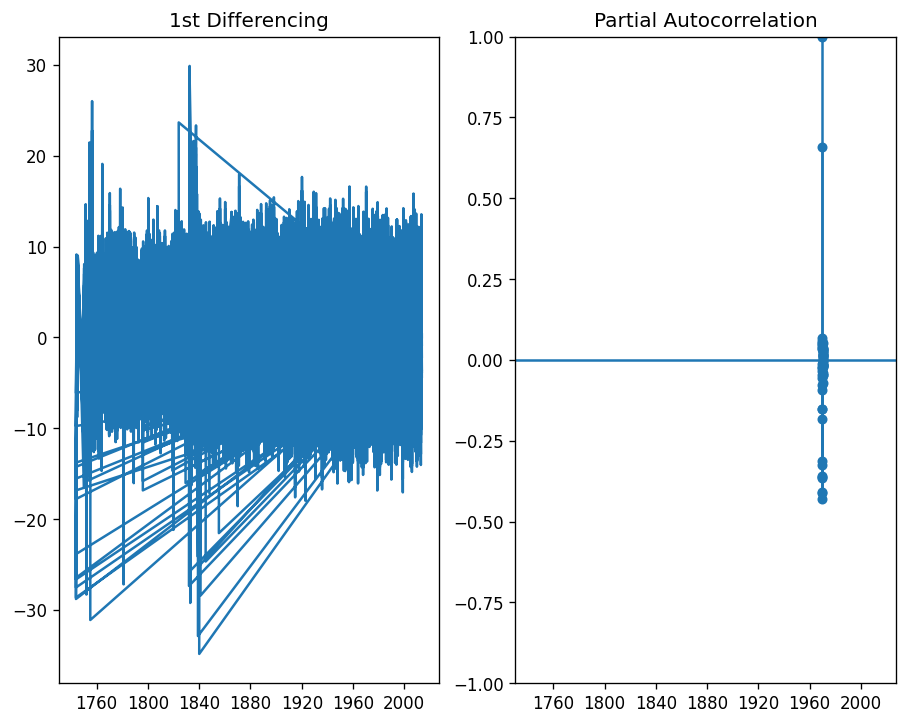

In [109]:
# PACF plot of 1st differenced series
fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df["AverageTemperature"].diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(df["AverageTemperature"].diff().dropna(), ax=axes[1])

plt.show()

At the start of the Autocorrelation , we observe the negative value, meaning that very quickly seris are over differenciate.
In that situation we can't expect of lot from model. To be short we are in underfitting situation.
Graphics are not really clear. Anyway let's the ARIMA model, hoping we can observe some trends

In [110]:


# 1,1,1 ARIMA Model
df.index = pd.DatetimeIndex(df.index).to_period('M')

model_fit= ARIMA(df["AverageTemperature"], order=(1,1,1)).fit()
print(model_fit.summary())


c:\ProgramData\miniconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\ProgramData\miniconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\ProgramData\miniconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:     AverageTemperature   No. Observations:               228175
Model:                 ARIMA(1, 1, 1)   Log Likelihood             -560307.930
Date:                Mon, 26 Feb 2024   AIC                        1120621.860
Time:                        21:59:09   BIC                        1120652.874
Sample:                             0   HQIC                       1120630.936
                             - 228175                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5999      0.002    293.525      0.000       0.596       0.604
ma.L1          0.1092      0.002     48.345      0.000       0.105       0.114
sigma2         7.9513      0.014    553.693      0.0

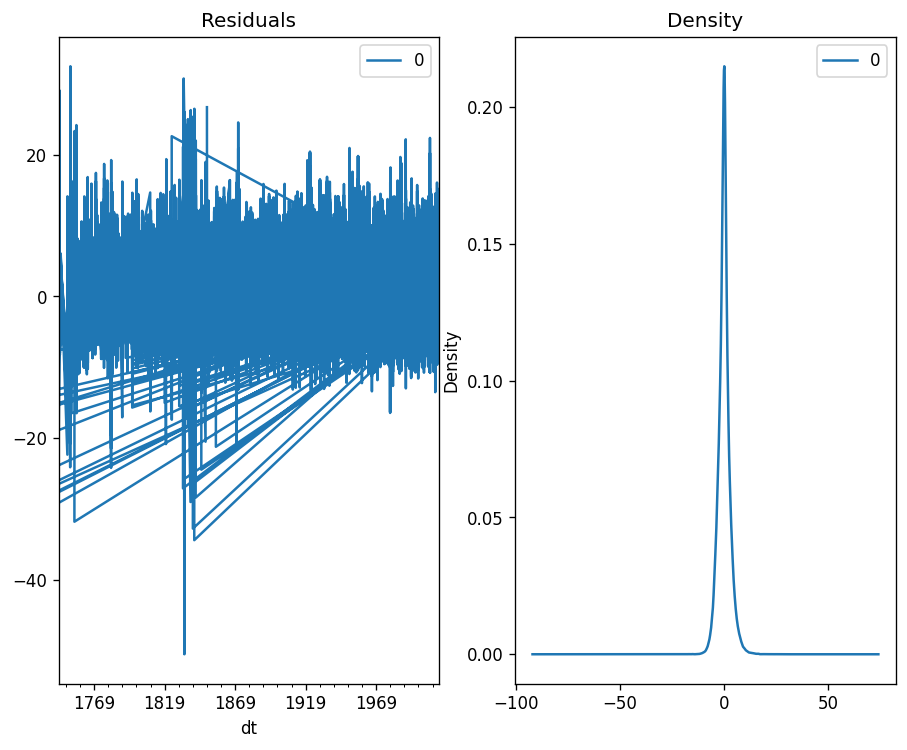

In [111]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()


As we said before, result are not very fun. 

The residual errors seem with near zero mean but  without uniform variance.

 Let’s plot the actuals against the fitted values using plot_predict().

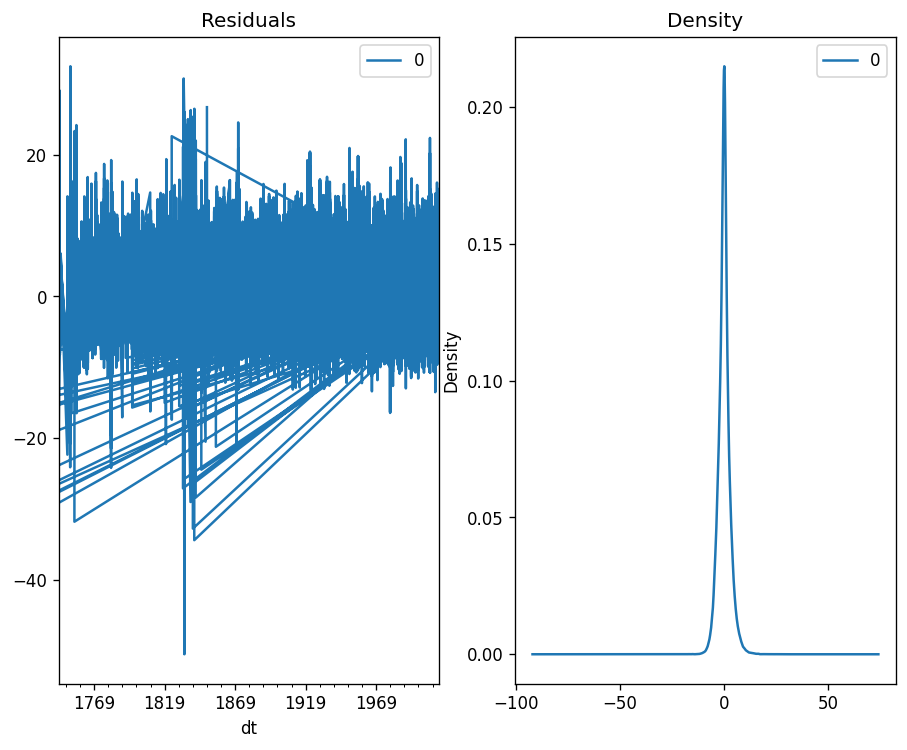

In [112]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

C:\Users\valentin\AppData\Local\Temp\ipykernel_11932\881924212.py:1: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'Y' instead.
  dta = df[["AverageTemperature"]].resample('A').mean()
C:\Users\valentin\AppData\Local\Temp\ipykernel_11932\881924212.py:1: FutureWarning: Resampling with a PeriodIndex is deprecated. Cast index to DatetimeIndex before resampling instead.
  dta = df[["AverageTemperature"]].resample('A').mean()
C:\Users\valentin\AppData\Local\Temp\ipykernel_11932\881924212.py:2: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  dta.index = pd.date_range(start='1743', end='2014', freq='A')
c:\ProgramData\miniconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


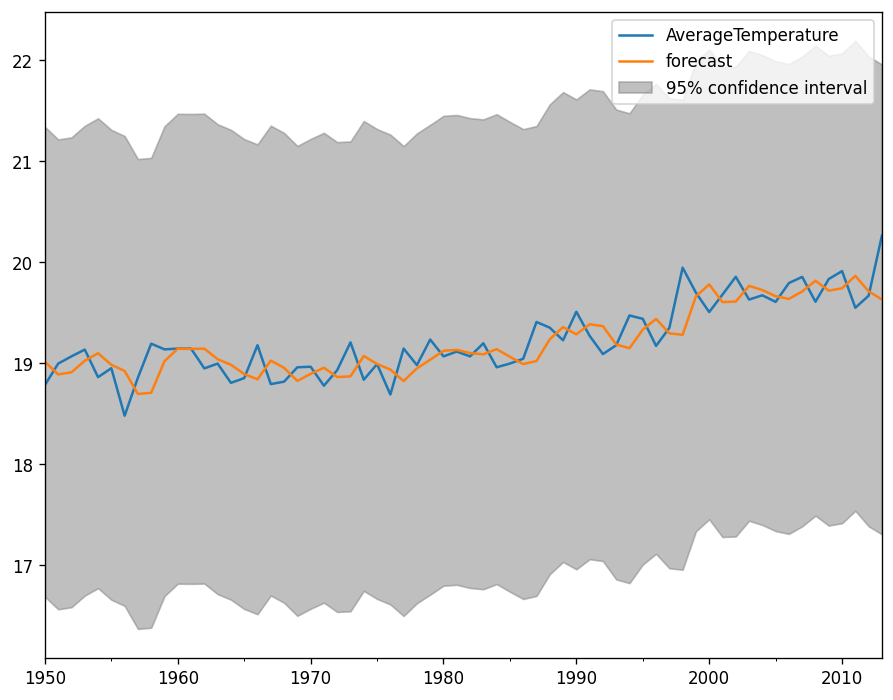

In [113]:
dta = df[["AverageTemperature"]].resample('A').mean()
dta.index = pd.date_range(start='1743', end='2014', freq='A')
res = ARIMA(dta, order=(1,1,1)).fit()
fig, ax = plt.subplots()
ax = dta.loc['1950':].plot(ax=ax)
plot_predict(res, '1950', '2013', ax=ax)
plt.show()

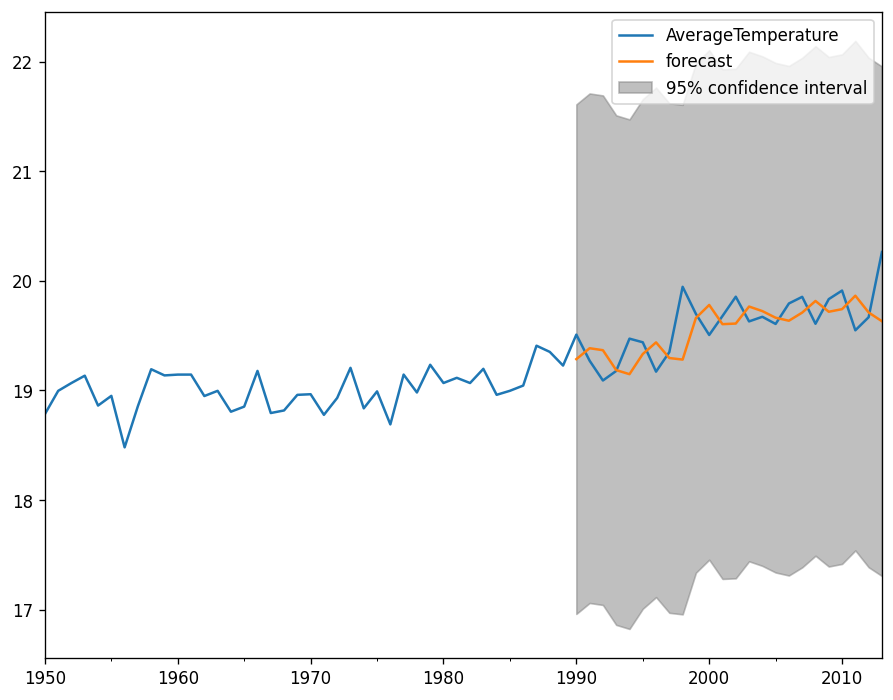

In [114]:
ig, ax = plt.subplots()
ax = dta.loc['1950':].plot(ax=ax)
plot_predict(res, '1990', '2013', ax=ax)
plt.show()

.
We confirm again the prior intuition namely our forecasting is not fun. 
Also it is on a few part of data to be visualizable.
To fix idea let's have a look on some metrics 

In [115]:
from statsmodels.tsa.stattools import acf

# Create Training and Test
train = dta[:178]
test = dta[178:]

In [117]:
model = ARIMA(train, order=(1, 1, 1))  
fitted = model.fit()
fc = fitted.forecast(93, alpha=0.05)

print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:     AverageTemperature   No. Observations:                  178
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -312.022
Date:                Mon, 26 Feb 2024   AIC                            630.044
Time:                        22:00:59   BIC                            639.573
Sample:                    12-31-1743   HQIC                           633.909
                         - 12-31-1920                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3553      0.201     -1.770      0.077      -0.749       0.038
ma.L1         -0.1082      0.223     -0.486      0.627      -0.544       0.328
sigma2         2.1414      0.083     25.700      0.0

c:\ProgramData\miniconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\ProgramData\miniconda3\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


In [118]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 
            'corr':corr, 'minmax':minmax})

forecast_accuracy(fc.values, test["AverageTemperature"].values)

{'mape': 0.021614417393993626,
 'me': -0.40847360308868647,
 'mae': 0.41926499729826183,
 'mpe': -0.021033224206665323,
 'rmse': 0.5414159351706695,
 'corr': -0.06185646216276959,
 'minmax': 0.02161221101043498}

# Machine Learning Approach

Here we will use classic scikit learn tools and algorithm in order to try obtaining better results.

In [ ]:
By_Major_City_numpy=np.array(ByMajorCity_true)
Years=[By_Major_City_numpy[k,0].year for k in range(len(By_Major_City_numpy))]
Month=[By_Major_City_numpy[k,0].month for k in range(len(By_Major_City_numpy))]

In [ ]:
ByMajorCity_true['Year']=Years
ByMajorCity_true['Month']=Month
ByMajorCity_true['Latitude'] = ByMajorCity_true['Latitude'].str[:-1]
ByMajorCity_true['Latitude'] = ByMajorCity_true['Latitude'].astype(float)

ByMajorCity_true['Longitude'] = ByMajorCity_true['Longitude'].str[:-1]
ByMajorCity_true['Longitude'] = ByMajorCity_true['Longitude'].astype(float)
ByMajorCity_true

,dt,AverageTemperature,Country,Latitude,Longitude,Year,Month
0,1849-01-01,26.704,11,5.63,3.23,1849,1
1,1849-02-01,27.434,11,5.63,3.23,1849,2
2,1849-03-01,28.101,11,5.63,3.23,1849,3
3,1849-04-01,26.140,11,5.63,3.23,1849,4
4,1849-05-01,25.427,11,5.63,3.23,1849,5
...,...,...,...,...,...,...,...
239171,2013-04-01,12.563,8,34.56,108.97,2013,4
239172,2013-05-01,18.979,8,34.56,108.97,2013,5
239173,2013-06-01,23.522,8,34.56,108.97,2013,6
239174,2013-07-01,25.251,8,34.56,108.97,2013,7


In [ ]:
#Now let's split our data into training and testing sets
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error


X = ByMajorCity_true.drop(columns=['AverageTemperature','dt'])
y = ByMajorCity_true['AverageTemperature']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Test de modèles

In [ ]:
#Fonction pour afficher les poids
def affichage_poids(model):
    # Obtention des poids
    feature_weights = model.coef_

    # Create a dictionary to pair feature names with their weights
    feature_weights_dict = dict(zip(X.columns.to_list(), feature_weights))
    # Assuming you've already created the feature_weights_dict
    feature_weights_df = pd.DataFrame(feature_weights_dict.items(), columns=['Variable', 'Poids'])

    transposed_df = feature_weights_df.transpose()

    # Display the DataFrame
    print('\n', transposed_df.to_string())

# Logistic Regression

In [ ]:
# Fonction objectif pour Optuna utilisant la Mean Squared Error (MSE)
def objective(trial):
    fit_intercept = trial.suggest_categorical('fit_intercept', [True, False])
    positive = trial.suggest_categorical('positive', [True, False])

    model = LinearRegression(fit_intercept=fit_intercept, positive=positive)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)

    return mse

# Création et exécution de l'étude Optuna
study_reglin = optuna.create_study(direction='minimize')
study_reglin.optimize(objective, n_trials=50)

# Obtention des meilleurs paramètres et calcul du MSE et du R2 avec les paramètres optimisés
best_params = study_reglin.best_params
best_model = LinearRegression(**best_params)
best_model.fit(X_train, y_train)
y_pred_best = best_model.predict(X_test)
mse_reglin= mean_squared_error(y_test, y_pred_best)
r2_reglin = r2_score(y_test, y_pred_best)

print('\n')
print(f"Meilleurs hyperparamètres: {best_params}")
print(f"MSE optimisé de LinearRegression: {mse_reglin}")
print(f"R2 correspondant: {r2_reglin}")
affichage_poids(best_model)

[I 2024-02-12 18:55:19,772] A new study created in memory with name: no-name-a0d99d14-09dd-4e90-9ff2-093856724908


[I 2024-02-12 18:55:19,931] Trial 0 finished with value: 61.102298786944246 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 0 with value: 61.102298786944246.
[I 2024-02-12 18:55:20,053] Trial 1 finished with value: 97.54090497323931 and parameters: {'fit_intercept': True, 'positive': True}. Best is trial 0 with value: 61.102298786944246.
[I 2024-02-12 18:55:20,180] Trial 2 finished with value: 98.45722051683858 and parameters: {'fit_intercept': False, 'positive': True}. Best is trial 0 with value: 61.102298786944246.
[I 2024-02-12 18:55:20,350] Trial 3 finished with value: 60.6011097307731 and parameters: {'fit_intercept': True, 'positive': False}. Best is trial 3 with value: 60.6011097307731.
[I 2024-02-12 18:55:20,494] Trial 4 finished with value: 98.45722051683858 and parameters: {'fit_intercept': False, 'positive': True}. Best is trial 3 with value: 60.6011097307731.
[I 2024-02-12 18:55:20,636] Trial 5 finished with value: 98.45722051683858 and parameters



Meilleurs hyperparamètres: {'fit_intercept': True, 'positive': False}
MSE optimisé de LinearRegression: 60.6011097307731
R2 correspondant: 0.39880656102690026

                  0         1          2         3         4
Variable   Country  Latitude  Longitude      Year     Month
Poids     0.037473 -0.448113  -0.010225  0.002833  0.300089


# RandomForestRegressor

In [ ]:
# On initialise avec aucune valeur d'hyperparamètres
r2_scores_rf = {'n_estimators': [], 'max_depth': [], 'min_samples_split': [], 'min_samples_leaf': []}
mse_scores_rf = {'n_estimators': [], 'max_depth': [], 'min_samples_split': [], 'min_samples_leaf': []}
hyperparameters = {'n_estimators': [], 'max_depth': [], 'min_samples_split': [], 'min_samples_leaf': []}

def objective_rf(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 100),
        'max_depth': trial.suggest_int('max_depth', 2, 32, log=True),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
    }
    
    rf = RandomForestRegressor(**params)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    
    # Stocke les scores R2 et MSE pour chaque hyperparamètre
    for param_name, param_value in params.items():
        r2_scores_rf[param_name].append(r2)
        hyperparameters[param_name].append(param_value)
        mse_scores_rf[param_name].append(mse)
    
    return mse  # Optuna cherche à minimiser, donc utilise la MSE


# Crée une étude Optuna pour RandomForestRegressor
study_rf = optuna.create_study(direction='minimize')
study_rf.optimize(objective_rf, n_trials=100)

# Obtient l'indice du meilleur score MSE à travers tous les hyperparamètres
best_mse_index = np.argmin([min(mses) for mses in mse_scores_rf.values()])

# Extrait les meilleurs hyperparamètres
best_hyperparameters = {param_name: values[best_mse_index] for param_name, values in hyperparameters.items()}

print('\n')
print("Meilleurs hyperparamètres:")
for param_name, param_value in best_hyperparameters.items():
    print(f"{param_name}: {param_value}")

best_mse_RandomForest = min([min(mses) for mses in mse_scores_rf.values()])
r2_RandomForest = max([max(scores) for scores in r2_scores_rf.values()])
print(f"Meilleure MSE: {best_mse_RandomForest:.4f}")
print(f"R2 correspondant: {r2_RandomForest:.4f}")

#Affichage des poids
best_RandomForest= RandomForestRegressor(**study_rf.best_params)
best_RandomForest.fit(X_train, y_train)

# Obtention du poids des variables
feature_importance = best_RandomForest.feature_importances_

# Création d'un DataFrame pour afficher les importances des variables
importance_df = pd.DataFrame({'Variable': X_train.columns, 'Poids': feature_importance})
importance_df = importance_df.sort_values('Poids', ascending=False)

print("\n Importance des variables :")
importance=importance_df.T
print(importance.to_string())


with open('study_rf.pkl', 'wb') as f:
    pickle.dump(study_rf, f)
    
with open('study_rf.pkl', 'rb') as f:
    study_rf = pickle.load(f)

[I 2024-02-12 22:59:53,188] A new study created in memory with name: no-name-1dbb3909-10f5-4f51-867c-aed48cdf1fde
[I 2024-02-12 23:00:04,816] Trial 0 finished with value: 25.459602140557195 and parameters: {'n_estimators': 60, 'max_depth': 4, 'min_samples_split': 19, 'min_samples_leaf': 5}. Best is trial 0 with value: 25.459602140557195.
[I 2024-02-12 23:00:21,402] Trial 1 finished with value: 47.15604035220384 and parameters: {'n_estimators': 75, 'max_depth': 2, 'min_samples_split': 12, 'min_samples_leaf': 9}. Best is trial 0 with value: 25.459602140557195.
[I 2024-02-12 23:01:42,457] Trial 2 finished with value: 2.7706132112965816 and parameters: {'n_estimators': 79, 'max_depth': 11, 'min_samples_split': 10, 'min_samples_leaf': 1}. Best is trial 2 with value: 2.7706132112965816.
[I 2024-02-12 23:02:33,825] Trial 3 finished with value: 1.2810219363003068 and parameters: {'n_estimators': 41, 'max_depth': 25, 'min_samples_split': 2, 'min_samples_leaf': 8}. Best is trial 3 with value: 1.



Meilleurs hyperparamètres:
n_estimators: 60
max_depth: 4
min_samples_split: 19
min_samples_leaf: 5
Meilleure MSE: 1.2671
R2 correspondant: 0.9874

 Importance des variables :
                 1         4          2         0         3
Variable  Latitude     Month  Longitude   Country      Year
Poids     0.532454  0.328871    0.08618  0.048255  0.004241


# Gradient Boosting Regressor

In [47]:
# Définition de la fonction objectif pour Optuna
def objectif(trial):
    # Définition de l'espace de recherche des hyperparamètres
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 100),
        'learning_rate': trial.suggest_int('learning_rate', 0, 1000),
        'min_weight_fraction_leaf': trial.suggest_float('min_weight_fraction_leaf', 0.0, 0.5),
        'max_depth': trial.suggest_int('max_depth', 2, 32, log=True),
        'min_impurity_decrease': trial.suggest_int('min_impurity_decrease', 0, 1000),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
    }

    # Création du modèle avec les hyperparamètres choisis
    model = GradientBoostingRegressor(**params)

    # Entraînement du modèle
    model.fit(X_train, y_train)

    # Prédictions sur l'ensemble de validation
    y_pred = model.predict(X_test)

    # Retourne la MSE négative car Optuna cherche à minimiser l'objectif
    return mean_squared_error(y_test, y_pred)

# Création d'une étude Optuna pour minimiser la MSE
studyGBR = optuna.create_study(direction='minimize')
studyGBR.optimize(objectif, n_trials=100)

# Récupération des meilleurs paramètres de l'étude
meilleurs_params = studyGBR.best_params
meilleur_trial = studyGBR.best_trial

print('\n')
print("Meilleurs Paramètres:", meilleurs_params)

# Création d'un modèle avec les hyperparamètres optimaux
meilleur_model = GradientBoostingRegressor(**meilleurs_params)
meilleur_model.fit(X_train, y_train)
y_pred = meilleur_model.predict(X)

# Calcul du MSE et du R2 avec les hyperparamètres optimaux
mseGBR = mean_squared_error(y, y_pred)
r2GBR = r2_score(y, y_pred)

print("Mean Squared Error:", mseGBR)
print("R-squared:", r2GBR)

# Accéder aux poids des différentes variables
importances = meilleur_model.feature_importances_

# Créer une liste des noms de variables
noms_variables = list(X_train.columns) 

# Associer les poids aux noms de variables
importance_df = pd.DataFrame({'Variable': X_train.columns, 'Poids': importances})
importance_df = importance_df.sort_values('Poids', ascending=False)

# Afficher les poids des différentes variables
print("\n Importances des variables :")
importance=importance_df.T
print(importance.to_string())


with open('studyGBR.pkl', 'wb') as f:
    pickle.dump(studyGBR, f)
    
with open('studyGBR.pkl', 'rb') as f:
    studyGBR = pickle.load(f)


[I 2024-02-12 23:35:17,380] A new study created in memory with name: no-name-c3ef6d17-04ff-47ac-8fb6-fddf8a9ee5f2
[I 2024-02-12 23:35:25,119] Trial 0 finished with value: 2.9071568898723125e+95 and parameters: {'n_estimators': 26, 'learning_rate': 64, 'min_weight_fraction_leaf': 0.02287420084632552, 'max_depth': 20, 'min_impurity_decrease': 80, 'min_samples_leaf': 2}. Best is trial 0 with value: 2.9071568898723125e+95.
C:\Users\valentin\AppData\Roaming\Python\Python311\site-packages\numpy\core\_methods.py:49: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
C:\Users\valentin\AppData\Roaming\Python\Python311\site-packages\numpy\core\_methods.py:49: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
C:\Users\valentin\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_regression.py:501: RuntimeWarning: overflow encountered in square
  output_errors = np.av



Meilleurs Paramètres: {'n_estimators': 20, 'learning_rate': 1, 'min_weight_fraction_leaf': 0.11423580927305693, 'max_depth': 26, 'min_impurity_decrease': 862, 'min_samples_leaf': 2}
Mean Squared Error: 12.427460764326584
R-squared: 0.8763389598541953

 Importances des variables :
                 1         4          2         0         3
Variable  Latitude     Month  Longitude   Country      Year
Poids     0.585932  0.325782   0.046303  0.040769  0.001214


Here is the model that needs to be outperformed in this challenge.